# Node classification with Relational Graph Convolutional Network (RGCN)


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/rgcn-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/rgcn-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This example demonstrates how use an RGCN [1] on the AIFB dataset with stellargraph. 

[1] Modeling Relational Data with Graph Convolutional Networks. Thomas N. Kipf, Michael Schlichtkrull (2017). https://arxiv.org/pdf/1703.06103.pdf

First we load the required libraries.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.3.0b

In [3]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

# try:
#     sg.utils.validate_notebook_version("1.3.0b")
# except AttributeError:
#     raise ValueError(
#         f"This notebook requires StellarGraph version 1.3.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
#     ) from None

In [4]:
from rdflib.extras.external_graph_libs import *
from rdflib import Graph, URIRef, Literal

import networkx as nx
from networkx.classes.function import info

import stellargraph as sg
from stellargraph.mapper import RelationalFullBatchNodeGenerator
from stellargraph.layer import RGCN
from sklearn import preprocessing, model_selection

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

import sklearn
from sklearn import model_selection
from collections import Counter
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [5]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()
print(node_subjects)
print(G)
# print(G[0])
# G=G[0]

31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
                    ...          
1128975        Genetic_Algorithms
1128977        Genetic_Algorithms
1128978        Genetic_Algorithms
117328                 Case_Based
24043             Neural_Networks
Name: subject, Length: 2708, dtype: object


In [6]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [7]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [8]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [9]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


The relationship 'affiliation' indicates whether a researcher is affiliated with a research group e.g. (researcher, research group, affiliation). This is used to create the one-hot labels in the `affiliation` DataFrame. These relationships are not included in `G` (nor is its inverse relationship 'employs'). The idea here is to test whether we can recover a 'missing' relationship. 

## Input preparation

The nodes don't natively have features, so they've been replaced with one-hot indicators to allow the model to learn from the graph structure. We're only training on the people with affiliations, so we split that into train and test splits.

In [10]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)
val_targets

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [11]:
generator = RelationalFullBatchNodeGenerator(G, sparse=True)

train_gen = generator.flow(train_subjects.index, targets=train_targets)
test_gen = generator.flow(test_subjects.index, targets=test_targets)

## RGCN model creation and training

We use stellargraph to create an RGCN object. This creates a stack of relational graph convolutional layers. We add a softmax layer to transform the features created by RGCN into class predictions and create a Keras model.  Then we train the model on the stellargraph generators.

Each RGCN layer creates a weight matrix for each relationship in the graph. If `num_bases==0` these weight matrices are completely independent. If `num_bases!=0` each weight matrix is a different linear combination of the same basis matrices. This introduces parameter sharing and reduces the number of the parameters in the model.  See the paper for more details.

In [12]:
rgcn = RGCN(
    layer_sizes=[32, 32],
    activations=["relu", "relu"],
    generator=generator,
    bias=True,
    num_bases=20,
    dropout=0.5,
)

In [13]:
x_in, x_out = rgcn.in_out_tensors()
predictions = Dense(train_targets.shape[-1], activation="softmax")(x_out)
model = Model(inputs=x_in, outputs=predictions)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(0.01),
    metrics=["acc"],
)

In [14]:
history = model.fit(train_gen, validation_data=test_gen, epochs=20)

Epoch 1/20
1/1 [==============================] - 1s 721ms/step - loss: 2.0211 - acc: 0.0786 - val_loss: 1.8478 - val_acc: 0.3395
Epoch 2/20
1/1 [==============================] - 0s 100ms/step - loss: 1.7935 - acc: 0.3643 - val_loss: 1.6614 - val_acc: 0.3341
Epoch 3/20
1/1 [==============================] - 0s 102ms/step - loss: 1.5165 - acc: 0.3929 - val_loss: 1.4535 - val_acc: 0.3917
Epoch 4/20
1/1 [==============================] - 0s 105ms/step - loss: 1.2217 - acc: 0.4643 - val_loss: 1.1853 - val_acc: 0.5803
Epoch 5/20
1/1 [==============================] - 0s 103ms/step - loss: 0.8202 - acc: 0.7214 - val_loss: 0.9722 - val_acc: 0.6659
Epoch 6/20
1/1 [==============================] - 0s 103ms/step - loss: 0.5969 - acc: 0.7714 - val_loss: 0.8342 - val_acc: 0.7273
Epoch 7/20
1/1 [==============================] - 0s 97ms/step - loss: 0.4118 - acc: 0.8571 - val_loss: 0.7564 - val_acc: 0.7631
Epoch 8/20
1/1 [==============================] - 0s 105ms/step - loss: 0.4252 - acc: 0.814

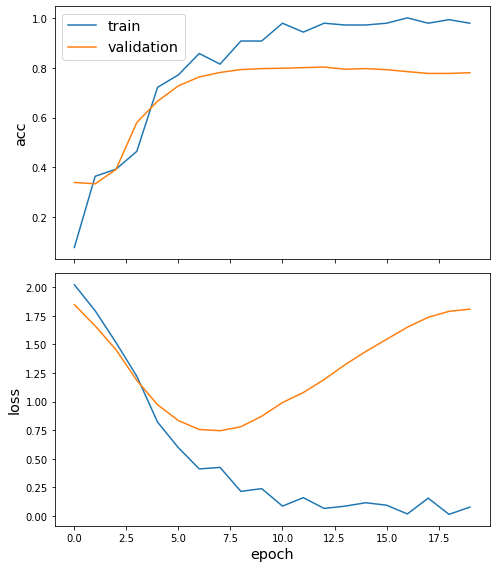

In [15]:
sg.utils.plot_history(history)

Now we assess the accuracy of our trained model on the test set - it does pretty well on this example dataset!

In [16]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 39ms/step - loss: 1.8078 - acc: 0.7800

Test Set Metrics:
	loss: 1.8078
	acc: 0.7800


## Node embeddings

We evaluate node embeddings as the activations of the output of the last graph convolution layer in the GCN layer stack and visualise them, coloring nodes by their true subject label. We expect to see nice clusters of researchers in the node embedding space, with researchers from the same group belonging to the same cluster.

To calculate the node embeddings rather than the class predictions, we create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings `x_out` rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# get embeddings for all people nodes
all_gen = generator.flow(node_subjects.index, targets=node_subjects)
embedding_model = Model(inputs=x_in, outputs=x_out)
emb = embedding_model.predict(all_gen)


In [18]:
node_subjects_df = node_subjects.to_frame()
node_subjects_df['subject'] = pd.Categorical(node_subjects_df['subject'])
node_subjects_df['subject'] = node_subjects_df['subject'].cat.codes
node_subjects_df

,subject
31336,2
1061127,5
1106406,4
13195,4
37879,3
...,...
1128975,1
1128977,1
1128978,1
117328,0


In [19]:
X = emb.squeeze(0)
y = node_subjects_df.idxmax(axis="columns").astype("category")

if X.shape[1] > 2:
    transform = TSNE

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_subjects.index)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_subjects.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 31336      subject
1061127    subject
1106406    subject
13195      subject
37879      subject
            ...   
1128975    subject
1128977    subject
1128978    subject
117328     subject
24043      subject
Name: label, Length: 2708, dtype: category
Categories (1, object): ['subject']

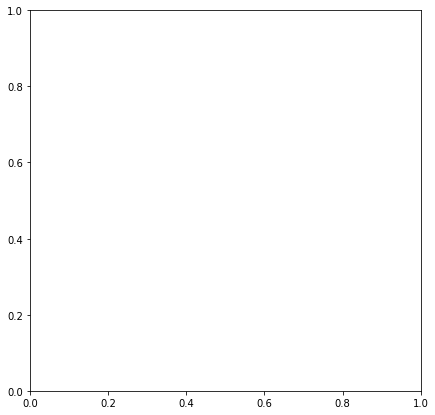

In [21]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].cat.codes,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of RGCN embeddings for AIFB dataset".format(transform.__name__)
)
plt.show()

Aside from a slight overlap the classes are well separated despite only using 2-dimensions. This indicates that our model is performing well at clustering the researchers into the right groups.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/rgcn-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/rgcn-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>